### 0.导入包并设置GPU

In [1]:
import os,sys
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import tensorflow as tf 
phy_gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in phy_gpus:
   tf.config.experimental.set_memory_growth(gpu,True)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import *

### 1.搭建VGG16模型

In [2]:
# Build VGG16 with Keras Sequential Model
def VGG16(input_shape=(224,224,3),classes=1000,include_top=True):

    # check include_top and classes
    if include_top and classes!=1000:
        raise ValueError("if include_top is True,classes should be 1000.")

    model = Sequential()

    # Block 1
    model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=3,strides=1,padding='same',activation='relu',name='block1_conv1'))
    model.add(Conv2D(64,3,strides=1,padding='same',activation='relu',name='block1_conv2'))
    model.add(MaxPooling2D(2,2,'same',name='block1_maxpool'))

    # Block 2
    model.add(Conv2D(128,3,strides=1,padding='same',activation='relu',name='block2_conv1'))
    model.add(Conv2D(128,3,strides=1,padding='same',activation='relu',name='block2_conv2'))
    model.add(MaxPooling2D(2,2,'same',name='block2_maxpool'))

    # Block 3
    model.add(Conv2D(256,3,strides=1,padding='same',activation='relu',name='block3_conv1'))
    model.add(Conv2D(256,3,strides=1,padding='same',activation='relu',name='block3_conv2'))
    model.add(Conv2D(256,3,strides=1,padding='same',activation='relu',name='block3_conv3'))
    model.add(MaxPooling2D(2,2,'same',name='block3_maxpool'))

    # Block 4
    model.add(Conv2D(512,3,strides=1,padding='same',activation='relu',name='block4_conv1'))
    model.add(Conv2D(512,3,strides=1,padding='same',activation='relu',name='block4_conv2'))
    model.add(Conv2D(512,3,strides=1,padding='same',activation='relu',name='block4_conv3'))
    model.add(MaxPooling2D(2,2,'same',name='block4_maxpool'))

    # Block 5
    model.add(Conv2D(512,3,strides=1,padding='same',activation='relu',name='block5_conv1'))
    model.add(Conv2D(512,3,strides=1,padding='same',activation='relu',name='block5_conv2'))
    model.add(Conv2D(512,3,strides=1,padding='same',activation='relu',name='block5_conv3'))
    model.add(MaxPooling2D(2,2,'same',name='block5_maxpool'))

    # include fc layer
    if include_top:
        model.add(Flatten(name='flatten'))
        model.add(Dense(4096,activation='relu',name='fc_layer1'))
        model.add(Dense(4096,activation='relu',name='fc_layer2'))
        model.add(Dense(classes,activation='softmax',name='predictions_layer'))

    return model

### 2.导入模型并加载预训练权重

In [3]:
weights_path = "./data/cat_vs_dog/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
model = VGG16(include_top=False,input_shape=(150,150,3),classes=2)
model.load_weights(weights_path)

In [4]:
#加上全连接层
model.add(Flatten(name='flatten'))
model.add(Dense(4096,activation='relu',name='fc_1'))
model.add(Dropout(0.3,name='dropout_1'))
model.add(Dense(4096,activation='relu',name='fc_2'))
model.add(Dropout(0.3,name='dropout_2'))
model.add(Dense(2,activation='softmax',name='predictions_layer'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_maxpool (MaxPooling2D (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_maxpool (MaxPooling2D (None, 38, 38, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 38, 38, 256)       2

### 3.处理数据

In [5]:
#指定训练数据增强生成方式
train_datagen = ImageDataGenerator(
    rotation_range = 40,width_shift_range = 0.2,height_shift_range = 0.2, rescale = 1/255,shear_range = 20,
    zoom_range = 0.2,horizontal_flip = True,fill_mode = 'nearest',) 
test_datagen = ImageDataGenerator(rescale = 1/255,) # 数据归一化 

batch_size = 64

# train_data
train_generator = train_datagen.flow_from_directory(
    './data/cat_vs_dog/dataset/train',
    target_size=(150,150),
    batch_size=batch_size)

# test_data
test_generator = test_datagen.flow_from_directory(
    './data/cat_vs_dog/dataset/test',
    target_size=(150,150),
    batch_size=batch_size )

Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### 4.训练模型

In [6]:
# train
model.compile(optimizer=SGD(lr=0.001,momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])
model.fit_generator(train_generator,steps_per_epoch=len(train_generator),
                    epochs=100,validation_data=test_generator,
                    validation_steps=len(test_generator))

model.save('./data/model_vgg16.h5',include_optimizer=True,save_format='h5')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
7/7 [==============================] - 4s 620ms/step - loss: 0.7408 - accuracy: 0.5250 - val_loss: 0.8222 - val_accuracy: 0.5000
Epoch 2/100
7/7 [==============================] - 3s 429ms/step - loss: 0.8231 - accuracy: 0.5075 - val_loss: 0.6242 - val_accuracy: 0.6300
Epoch 3/100
7/7 [==============================] - 3s 429ms/step - loss: 0.7007 - accuracy: 0.5850 - val_loss: 0.6337 - val_accuracy: 0.6200
Epoch 4/100
7/7 [==============================] - 3s 453ms/step - loss: 0.5936 - accuracy: 0.6775 - val_loss: 0.4501 - val_accuracy: 0.7800
Epoch 5/100
7/7 [==============================] - 3s 438ms/step - loss: 0.5268 - accuracy: 0.7325 - val_loss: 0.3770 - val_accuracy: 0.8300
Epoch 6/100
7/7 [==============================] - 3s 432ms/step - loss: 0.3851 - accuracy: 0.8100 - val_loss: 0.3523 - val_accuracy: 0.8300
Epoch 7/100
7/7 [==============================] - 3s 414ms/step - loss: 0.307

7/7 [==============================] - 17s 2s/step - loss: 0.0315 - accuracy: 0.9925 - val_loss: 0.2105 - val_accuracy: 0.9250
Epoch 56/100
7/7 [==============================] - 17s 2s/step - loss: 0.0252 - accuracy: 0.9950 - val_loss: 0.2544 - val_accuracy: 0.9200
Epoch 57/100
7/7 [==============================] - 17s 2s/step - loss: 0.0326 - accuracy: 0.9925 - val_loss: 0.3527 - val_accuracy: 0.8900
Epoch 58/100
7/7 [==============================] - 17s 2s/step - loss: 0.0227 - accuracy: 0.9950 - val_loss: 0.2470 - val_accuracy: 0.9200
Epoch 59/100
7/7 [==============================] - 17s 2s/step - loss: 0.0229 - accuracy: 0.9950 - val_loss: 0.2082 - val_accuracy: 0.9300
Epoch 60/100
7/7 [==============================] - 17s 2s/step - loss: 0.0292 - accuracy: 0.9900 - val_loss: 0.2921 - val_accuracy: 0.9150
Epoch 61/100
7/7 [==============================] - 17s 2s/step - loss: 0.0287 - accuracy: 0.9925 - val_loss: 0.2155 - val_accuracy: 0.9400
Epoch 62/100
7/7 [===============

### 5.用从网上随便找的图片来测试

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


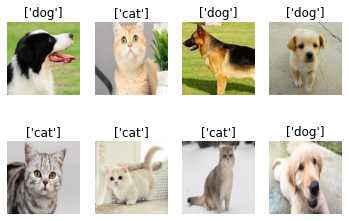

In [7]:
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import os

#加载模型
label = np.array(['cat','dog'])
model = load_model('./data/cat_vs_dog/model_vgg16.h5')

index = 1   
for img in os.listdir("./data/cat_vs_dog/tests/"):   
    file_name = "./data/cat_vs_dog/tests/"+img
    
    image = load_img(file_name)
    image = image.resize((150,150))
                     
    plt.subplot(2, 4, index)  
    index+=1
    plt.imshow(image)
    plt.axis('off')
                     
    image = img_to_array(image)
    image = image/255
    image = np.expand_dims(image,0) 
    plt.title(label[model.predict_classes(image)])

plt.show()